In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [192]:
df = pd.read_csv('.\datasets\current_data_without_preproc.csv')
df  = df.drop(columns=["Unnamed: 0.1","Unnamed: 0"])
# age_df = df["Age"].apply(np.floor)
# df["Age"] = df[["Age"]].replace(age_df[["Age"]], inplace=True)
# df
#print(df["Age"])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4313 entries, 0 to 4312
Data columns (total 50 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   EmployeeID                                                4313 non-null   object 
 1   Division                                                  4313 non-null   object 
 2   Department                                                4313 non-null   object 
 3   CostCenterName                                            4313 non-null   object 
 4   CostCenterCode                                            4313 non-null   object 
 5   Location                                                  4313 non-null   object 
 6   ResourceLevel                                             4313 non-null   int64  
 7   JobTitle                                                  4313 non-null   object 
 8   JobFunction       

In [193]:
def df_info(input_df):
    df_data = {}
    for column in list(input_df):
        data_to_append = {}
        # first sort through what type it is 
        ## Numerical data type workflow
        ## what if it's int32 or other variations? should i jsut convert this into a string then run .str.isnumeric operation on it?
        # using isinstance(x,int) would not work in pandas because pandas doesnt treat an int in the same way as in native python

        # Method 1 => hard code and account for all the possible dtypes 
        # Method 2 => convert dtypes to only int64 and float64, and manipulate from there

        if 'int' in input_df[f"{column}"].dtype or 'float' in input_df[f"{column}"].dtype:

        # if input_df[f"{column}"].dtype == "int64"  or input_df[f"{column}"].dtype == "int32" or input_df[f"{column}"].dtype == "int16" or input_df[f"{column}"].dtype == "int8" or input_df[f"{column}"].dtype == "uint64" or input_df[f"{column}"].dtype == "uint32" or input_df[f"{column}"].dtype == "uint16" or input_df[f"{column}"].dtype == "uint8" or input_df[f"{column}"].dtype == "int_" or input_df[f"{column}"].dtype == "float64" or input_df[f"{column}"].dtype == "float32" or input_df[f"{column}"].dtype == "float16" or input_df[f"{column}"].dtype == "float_":

            data_to_append["Data Type"] = "Numerical"
            
            # range
            max_value = input_df[f"{column}"].max()
            min_value = input_df[f"{column}"].min()
            data_to_append["Range"] = str(min_value) + "-" + str(max_value)

        elif input_df[f"{column}"].dtype == "str" or input_df[f"{column}"].dtype == "O":
            data_to_append["Data Type"] = "Categorical"
            number_of_unique_values = input_df[f"{column}"].nunique()
            data_to_append["Unique Values"] = number_of_unique_values

        #datetime type
        elif input_df[f"{column}"].dtype == "datetime64":
            data_to_append["Data Type"] = "Date Time"

        elif input_df[f"{column}"].dtype == "bool":
            data_to_append["Data Type"] = "Boolean"

    # from there => add more details for each column respectively
        df_data[f"{column}"] = data_to_append
    
    return df_data

# print(df_info(df))

# output1 = {
#     "col a": {
#         "data type": "numeric/categorical/datetime" 
#         "if numeric - give range"
#         "if categorical - give number of unique values (i.e categories) " 
#     }
#     }

In [194]:
temp_df = df.copy(deep=True)
temp_df = temp_df[["Division", "Voluntary"]].dropna()
temp_df

,Division,Voluntary
0,Art Division,Yes
5,Game Division,No
13,GA Division,Yes
15,Game Division,Yes
33,GA Division,Yes
...,...,...
4306,Art Division,Yes
4307,Art Division,Yes
4308,Art Division,Yes
4310,Game Division,Yes


           Division Voluntary
0      Art Division       Yes
5     Game Division        No
13      GA Division       Yes
15    Game Division       Yes
33      GA Division       Yes
...             ...       ...
4306   Art Division       Yes
4307   Art Division       Yes
4308   Art Division       Yes
4310  Game Division       Yes
4311  Game Division       Yes

[1516 rows x 2 columns]
                 voluntary_resig  non_voluntary_resig
Division                                             
Art Division                 806                  228
Co-pub Division                6                    3
GA Division                  102                   35
Game Division                252                   84


<AxesSubplot:xlabel='Division'>

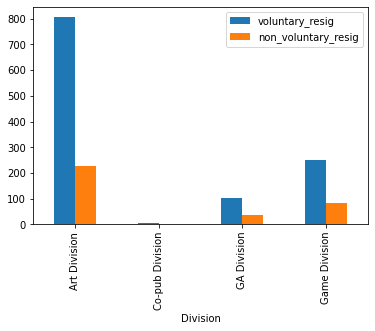

In [195]:
# Visual of count of voluntary and non-voluntary resignations based on Division / Location and gender?
# Div => categorical
# Location => categorical 
# Voluntary col is the only col that indicates the 

temp_df = df.copy(deep=True)
temp_df = temp_df[["Division", "Voluntary"]].dropna()
print(temp_df)
# # drop NaN
temp_df = temp_df.assign(
    voluntary_resig = np.where(temp_df["Voluntary"] == "Yes", 1, 0),
    non_voluntary_resig = np.where(temp_df["Voluntary"] == "No", 1, 0)
).groupby(["Division"]).agg({"voluntary_resig":sum,"non_voluntary_resig":sum})
# temp_df.columns=pd.MultiIndex.from_arrays(temp_df.iloc[0:3].values)
# temp_df=temp_df.iloc[0:3]
print(temp_df)
# g = sns.FacetGrid(temp_df, col=["Division"],height=4, aspect=.5)
# g.map(sns.barplot, ["voluntary_resig"], ["non_voluntary_resig"], order=["voluntary_resig", "non_voluntary_resig"])

# sns.barplot(x=["Division"], y=["voluntary_resig"], data=temp_df)
temp_df.plot(kind='bar')

In [210]:
# FEATURES = ['Division','Department','CostCenterName','Location','ResourceLevel','JobTitle','JobFunction','Gender','Grade','MgrResourceLevel','Avg annual bonus vs monthly base salary (previous year) ','Avg quarterly people review rating (last 3 times)','Avg Extra time hours/week(6 mths)','Avg Idle day ratio/month (3 mths)','Avg Inefficiency/month (3 mths)','Avg Occupation ratio/month (3 mths)','Job Satisfaction','Personal Development (satisfaction)','Support from Company','Last quarterly people review rating','Last annual performance rating','Service Years','Promotion frequency/last 2 yrs.','Avg Salary CR/month(6 mths)','Salary adjustment frequency present year','Salary increment Delta vs last year (%)','Age'
# ]
#USING these features to predict the status

def one_dimensional_quantitative_analysis_on_status(comparison_col_name, sort_by_col_name="Number_of_People_who_left"):
    # df.grade
    test_df = df.loc[:, [f"{comparison_col_name}", "Status"]]
    test_df = test_df.assign(
        Number_of_People_who_left = np.where(test_df[["Status"]] == 2, 1, 0),
        Number_of_People_who_stayed = np.where(test_df[["Status"]] == 3, 1, 0),
        ).groupby([f"{comparison_col_name}"]).agg({f"{sort_by_col_name}":sum, "Number_of_People_who_stayed":sum}
    )
    test_df.sort_values(by=[f"{sort_by_col_name}"], ascending=False, inplace=True)
    #print(test_df.dtypes)
    #sns.catplot(kind="bar", x=f"{comparison_col_name}", y=f"{sort_by_col_name}", data=test_df)
    print(test_df) 

def two_dimensional_quantitative_analysis_on_status(primary_comparison_col, secondary_comparison_col):
    test_df = df.loc[:, [f"{primary_comparison_col}", f"{secondary_comparison_col}" ,  "Status"]]
    test_df = test_df.assign(
        Number_of_People_who_left = np.where(test_df[["Status"]] == 2, 1, 0),
        
        ).groupby([f"{primary_comparison_col}", f"{secondary_comparison_col}"]).agg({"Number_of_People_who_left":sum}
    )
    test_df.sort_values(by=[f"{primary_comparison_col}"], ascending=True, inplace=True)
    print(test_df)


#one_dimensional_quantitative_analysis_on_status("Division")

#two_dimensional_quantitative_analysis_on_status("Division", "Gender")
combined_col = []
# def parsing_input_dtypes(group_by_col, val_col):
#     print(type(group_by_col), type(val_col))
    
#     if type(group_by_col) == str and type(val_col) == str:
#         combined_col = group_by_col,val_col

#     elif (type(group_by_col) == str and type(val_col) == list):
#         val_col.insert(0, group_by_col)
#         combined_col = val_col

#     elif (type(group_by_col) == list and type(val_col) == str):
#         group_by_col.append(val_col)
#         combined_col = group_by_col

#     elif (type(group_by_col) == list and type(val_col) == list):
#         combined_col = group_by_col + val_col
#     print(combined_col)
#     return combined_col

def f(input_df: str, group_by_col, val_col):
    unique_vals = list(set(df[val_col])) # gives me the names of the unique vals within the values col
    num_unique_vals = len(unique_vals)
    new_col_name = ""
    op_type = 0
    #parsing_input_dtypes(group_by_col, val_col)
    if type(group_by_col) == str and type(val_col) == str:
        combined_col = group_by_col,val_col
        op_type = 1
    # If Im iterating through val col, it must be the og one. Right now its the newer one (which was altered) that's being iterated
    elif (type(group_by_col) == str and type(val_col) == list):
        val_col.insert(0, group_by_col)
        combined_col = val_col
        op_type = 2

    elif (type(group_by_col) == list and type(val_col) == str):
        group_by_col.append(val_col)
        combined_col = group_by_col
        op_type = 3

    elif (type(group_by_col) == list and type(val_col) == list):
        combined_col = group_by_col + val_col    
        op_type = 4
    print(val_col)
    test_df = input_df.loc[:, combined_col]
    if op_type == 1:
        for i in range(num_unique_vals):
            eval_col = np.where(test_df[val_col] == unique_vals[i], 1, 0)
            # creating the name of the col
            new_col_name = f"Count_of_{val_col}:{unique_vals[i]}"
            # creating the col in the df
            test_df[new_col_name] = eval_col.flatten()
            test_df[new_col_name] = test_df.groupby([group_by_col])[new_col_name].transform("sum")
            
            #test_df[new_col_name] = test_df[new_col_name].groupby()
            #test_df[f"{val_col}"] = pd.Series(eval_col.flatten()).groupby([f"{group_by_col}"]).agg({f"{val_col}":sum})
            # eval col is not connected with the tesst df thats why its not working
            # find out whether this iterates throughout the whole col before going from value 2 to 3 => it does evaluate throughout the whole col before moving on to the next
            # test_df = test_df.assign(
            #     eval_val = list(eval_val)
            # ).groupby([f"{group_by_col}"]).agg({f"{val_col}":sum})
        test_df = test_df.drop_duplicates([group_by_col])
        test_df = test_df.drop([val_col], axis=1)
    
    # 1 group by, mulitple val cols
    elif op_type == 2:
        for j in range(len(val_col)):
            for i in range(num_unique_vals):
                eval_col = np.where(test_df[val_col][j] == unique_vals[i], 1, 0)
                # creating the name of the col
                new_col_name = f"Count_of_{val_col[j]}:{unique_vals[i]}"
                # creating the col in the df
                test_df[new_col_name] = eval_col.flatten()
                # do this final step twice
                test_df[new_col_name] = test_df.groupby([group_by_col])[new_col_name].transform("sum")

            test_df = test_df.drop_duplicates([group_by_col])
            test_df = test_df.drop([val_col][j], axis=1)

    print(test_df)
list_of_group_by_cols = ["Division", "Location"]
list_of_val_cols = ["Status", "Voluntary"]
#f(df, "Division", "Status")
f(df, "Division", list_of_val_cols)
# f(df, list_of_group_by_cols, "Status")
#f(df, list_of_group_by_cols, list_of_val_cols)




def viz():
    pass

# test_df = test_df.assign(
    #     # how to input the logic for any column?
    #     # have a for loop to iterate each row by the number of unique items in the col
    #     # whenever theres a match, count towards a diff sum
    #     # what I need: list of unique values, generate new list of col names (index numbers for list of unique values and the genrated col names must be the same)
    #     eval_val = (np.where(test_df[[f"{val_col}"]] == unique_vals[i], 1, 0) for i in range(num_unique_vals))
    # ).groupby([f"{group_by_col}"]).agg({f"{val_col}":sum}
    # )
    # # test_df.sort_values(by=[f"{val_col}"], ascending=False, inplace=True)
    # # print(test_df.dtypes)
    # # #sns.catplot(kind="bar", x=f"{comparison_col_name}", y=f"{sort_by_col_name}", data=test_df)
    # # return test_df

['Division', 'Status', 'Voluntary']


KeyError: 0

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

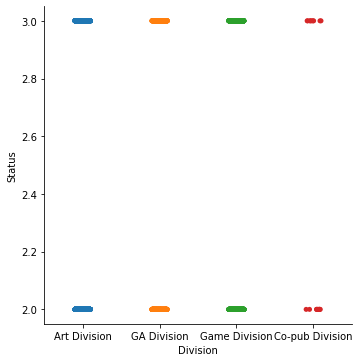

In [197]:
# FEATURES = ['Division','Department','CostCenterName','Location','ResourceLevel','JobTitle','JobFunction','Gender','Grade','MgrResourceLevel','Avg annual bonus vs monthly base salary (previous year) ','Avg quarterly people review rating (last 3 times)','Avg Extra time hours/week(6 mths)','Avg Idle day ratio/month (3 mths)','Avg Inefficiency/month (3 mths)','Avg Occupation ratio/month (3 mths)','Job Satisfaction','Personal Development (satisfaction)','Support from Company','Last quarterly people review rating','Last annual performance rating','Service Years','Promotion frequency/last 2 yrs.','Avg Salary CR/month(6 mths)','Salary adjustment frequency present year','Salary increment Delta vs last year (%)','Age'
# ]

# 
#one_dimensional_quantitative_analysis_on_status("Division")
sns.catplot(data=df, x=df["Division"], y=df["Status"], kind="strip")